In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


[main] Found existing base CSV: dfs_training/GOOGL_1_base.csv


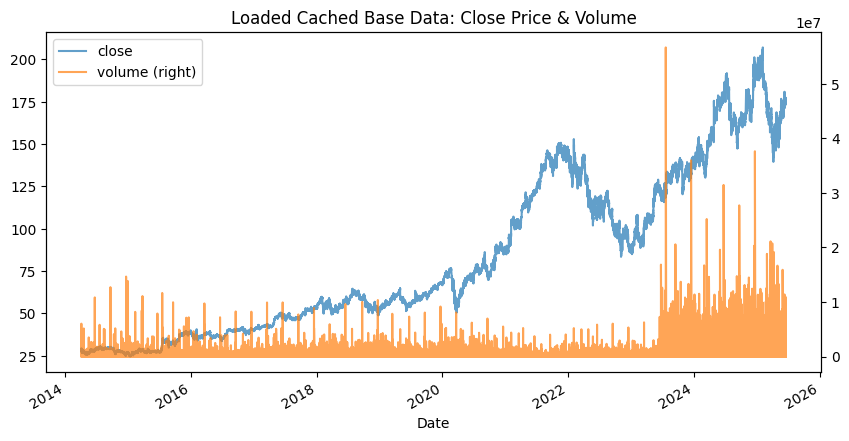

,open,high,low,close,volume,ask,bid
2014-04-03 10:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.617100,173.512900
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.432000,173.328000
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.362000,173.258000
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.332000,173.228000


In [2]:
ticker = params.ticker
month_to_plot = params.date_to_test # just used if date_to_check = None
date_to_check = params.date_to_check 
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
# df.groupby(df.index.hour)['volume'].mean().plot()

In [4]:
# df.index.max()

In [5]:
global_ref  = trades.compute_global_ref_profit(df = df)
global_ref # reference median used to scale the signal

0.2150000000000034

In [6]:

def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal_smooth',
                                         col_action='signal_action',
                                         ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal_raw',
        col_signal2='signal_smooth',
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [7]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_raw", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            dates_days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for date_day in sorted(dates_days.astype(str)):
                res = process_single_day(date_day, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            plots.aggregate_performance(performance_list, df_month)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode")
      
    print("\n•Running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df,
        col_signal='signal_smooth',
        col_action='signal_action',
        ref_profit=global_ref,
        day_to_check=None
    )

    print("\n•Merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    plots.aggregate_performance(performance_all, df_all)
    days_all = df_all.index.normalize().unique()

    # prepare the performances summary just for the test days
    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    plots.aggregate_performance(performance_test, df_test)    

    print("\n•Saving CSV …")
    ready_csv = params.ready_csv
    df_all.to_csv(ready_csv)
    print(f"Saved to {ready_csv}")

    return df_all




Full-run mode

•Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

•Merging, concatenating all days, and calculating test performances …

Overall Summary (2014-04-03 = 28.5931 → 2025-06-18 = 173.5576)

One-time buy&hold gain: 144.965
Buy & Hold – each day ($): -127.806
Strategy Return ($): 2172.211
Trades Count: 5506
Strategy return per trade: 0.395
Num. trading days: 2820
Strategy return per trading day: 0.770


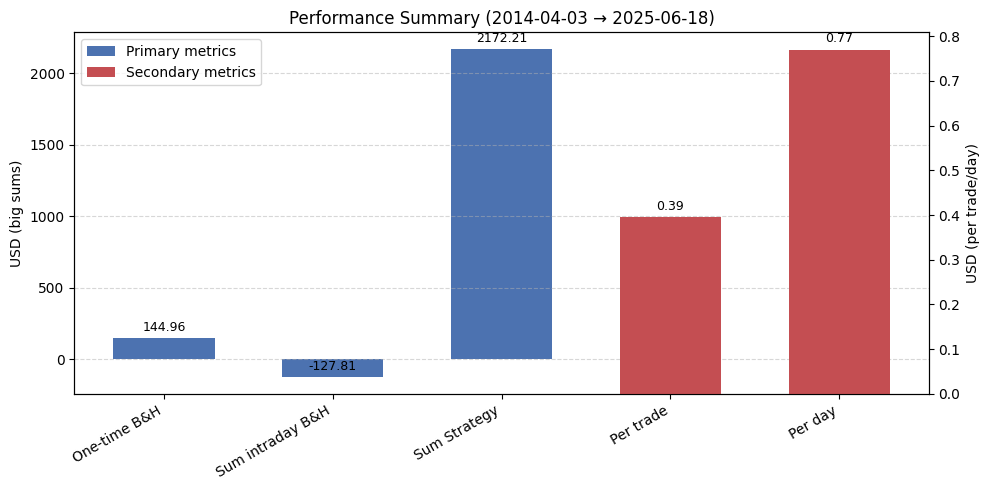


Overall Summary (2023-10-12 = 140.4855 → 2025-06-18 = 173.5576)

One-time buy&hold gain: 33.072
Buy & Hold – each day ($): -78.420
Strategy Return ($): 654.809
Trades Count: 1328
Strategy return per trade: 0.493
Num. trading days: 422
Strategy return per trading day: 1.552


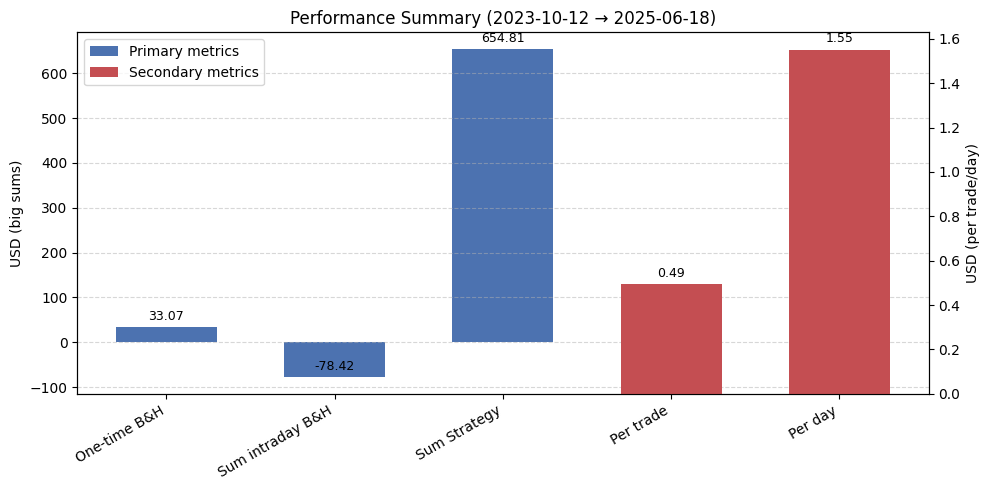


•Saving CSV …
Saved to dfs_training/GOOGL_2_ready.csv


,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal_raw,signal_smooth,signal_action
2014-04-03 10:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.000,0.000,0.121989,0.121989,0
2014-04-03 10:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.000,0.000,0.122489,0.122489,0
2014-04-03 10:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.000,0.000,0.122991,0.122991,0
2014-04-03 10:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.000,0.000,0.123494,0.123494,0
2014-04-03 10:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.000,0.000,0.123999,0.123999,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.512900,173.617100,0.734,3.444,0.001063,0.001063,0
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.328000,173.432000,0.734,3.629,0.005465,0.005465,0
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.258000,173.362000,0.734,3.699,0.007152,0.007152,0
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.228000,173.332000,0.734,3.729,0.007898,0.007898,0


In [8]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        smooth_win_sig=params.smooth_win_sig_tick, 
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick,
                        date_to_check=params.date_to_check
                        )

df_fin


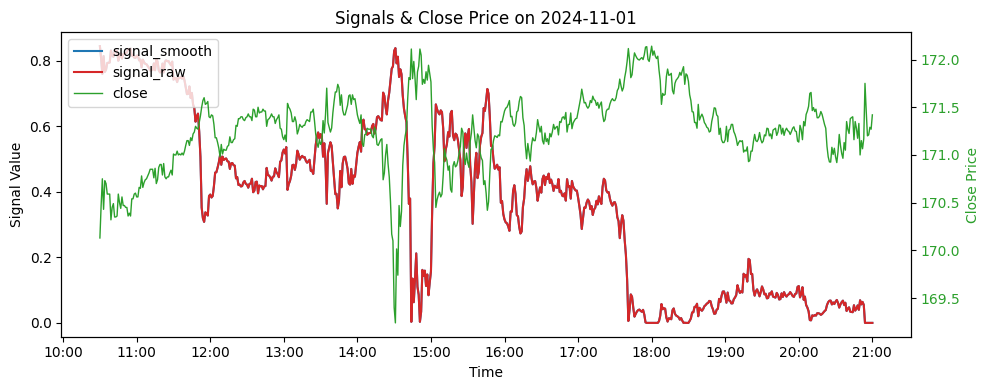

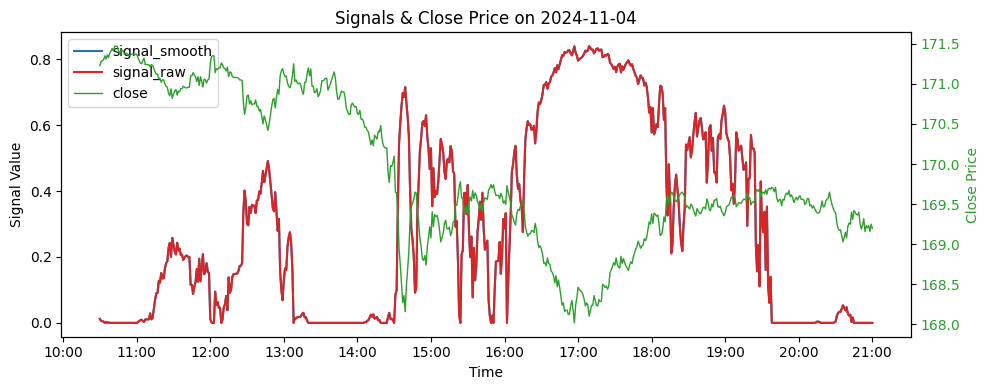

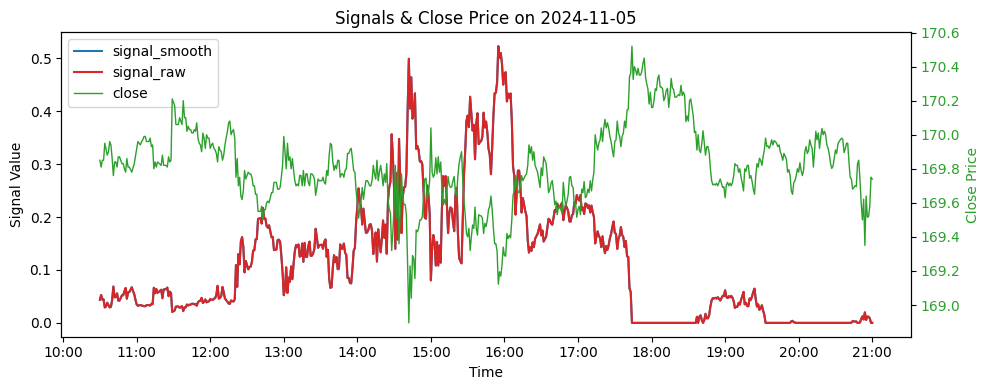

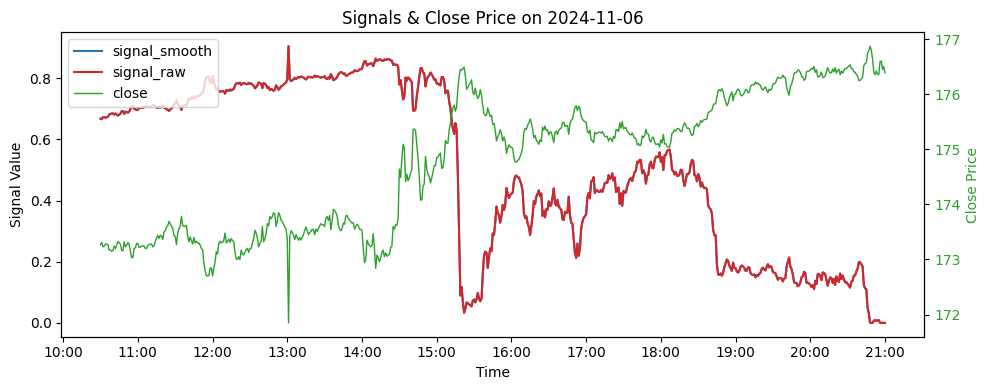

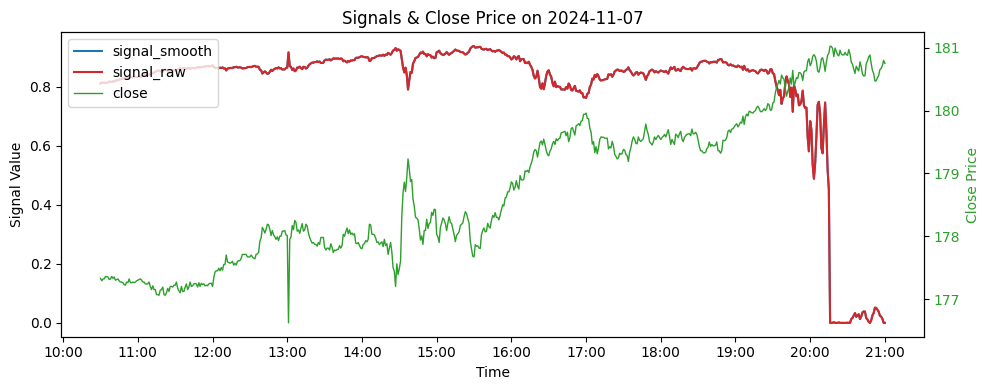

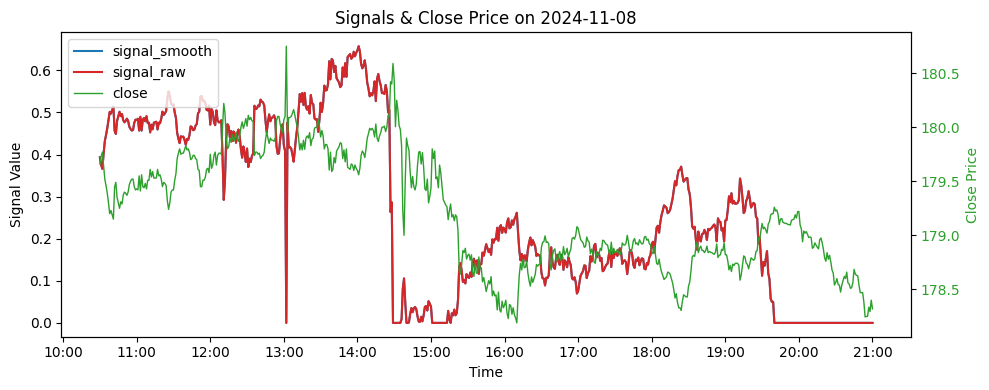

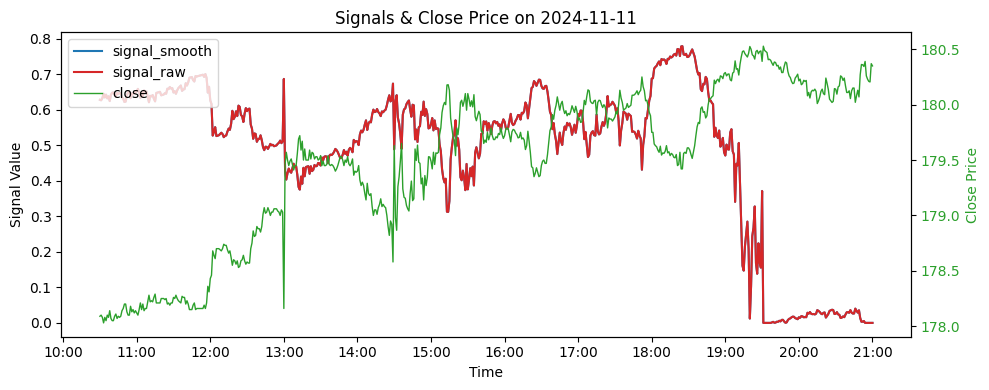

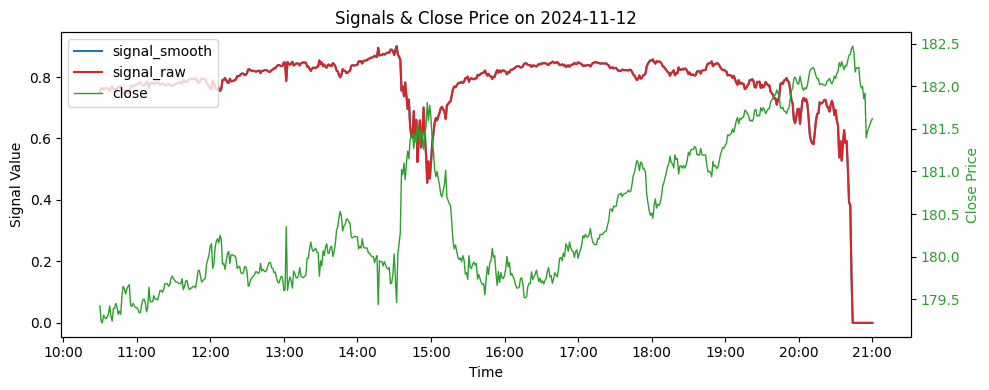

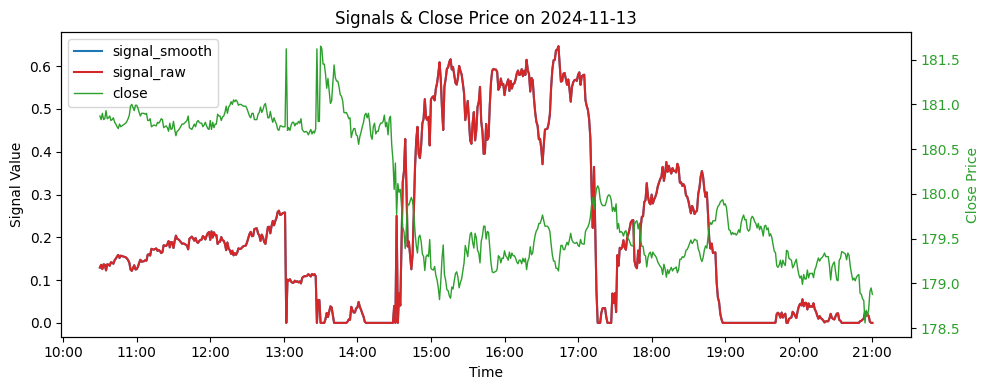

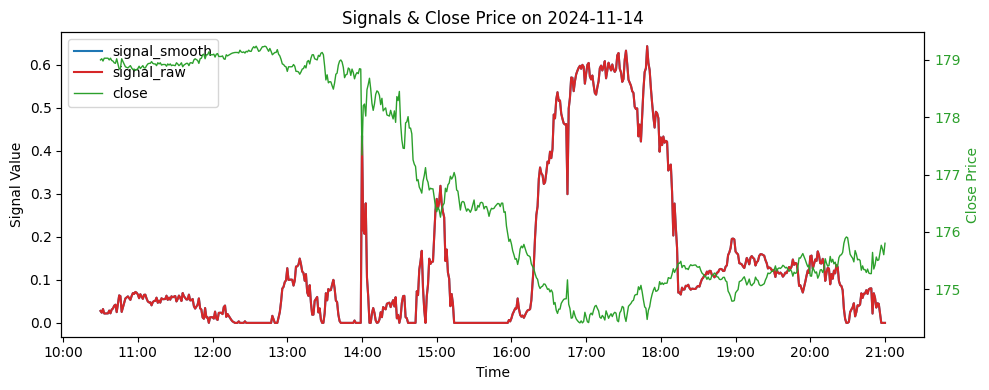

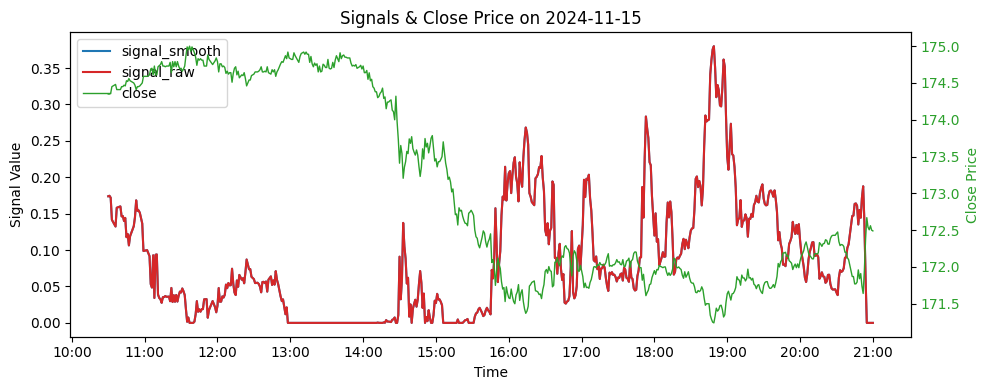

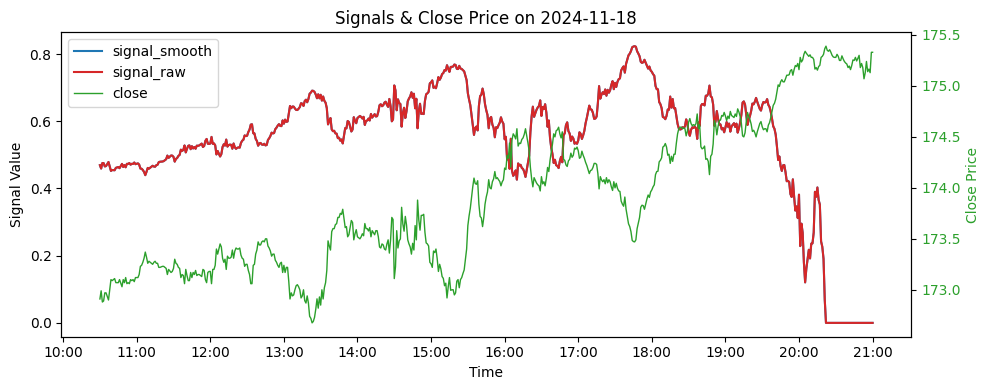

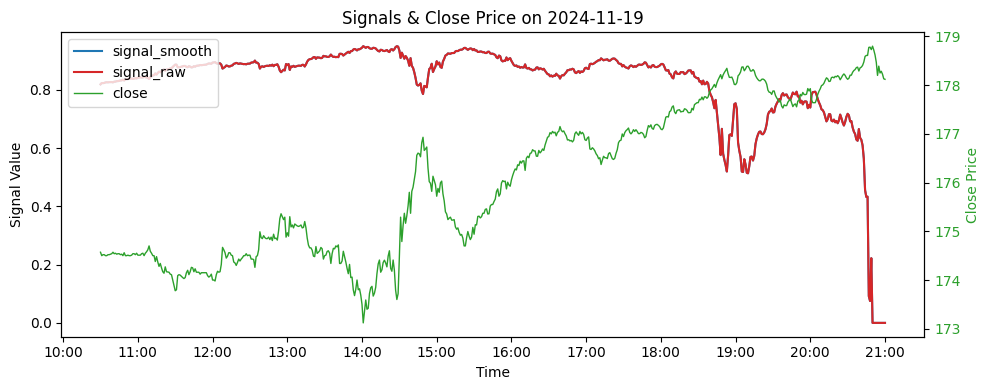

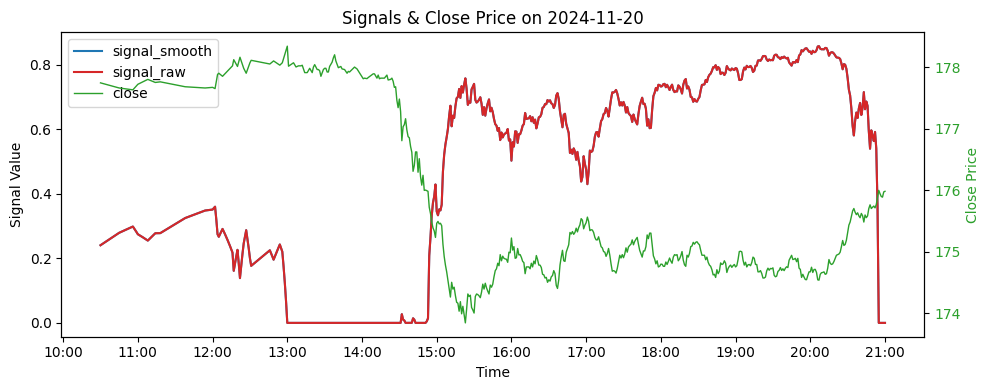

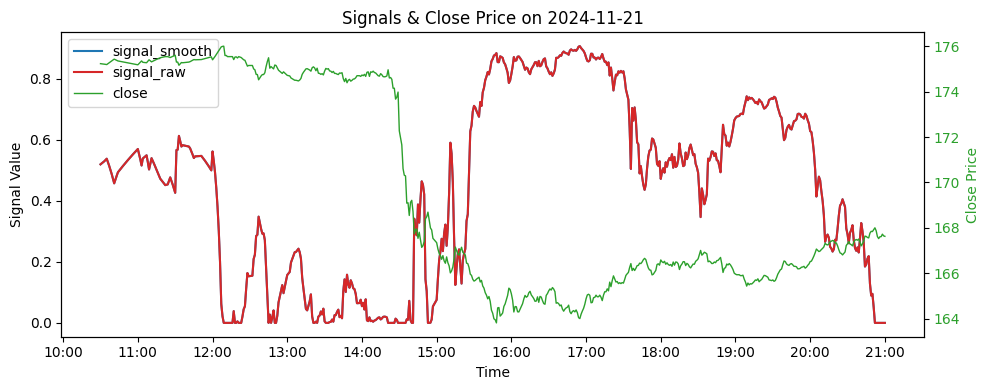

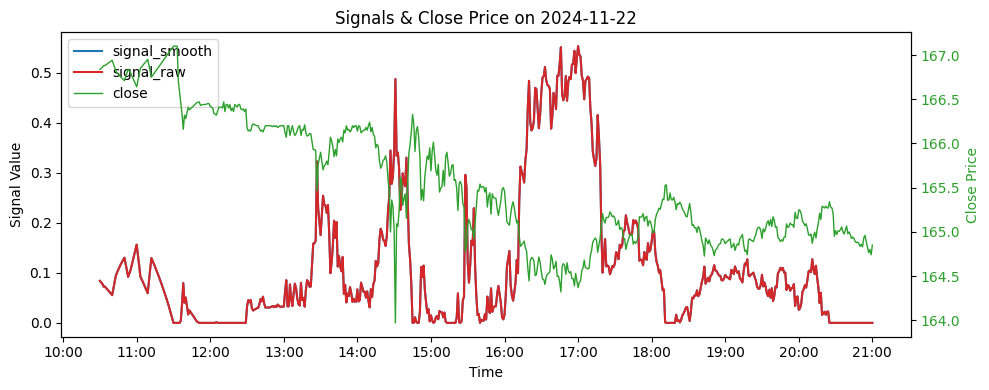

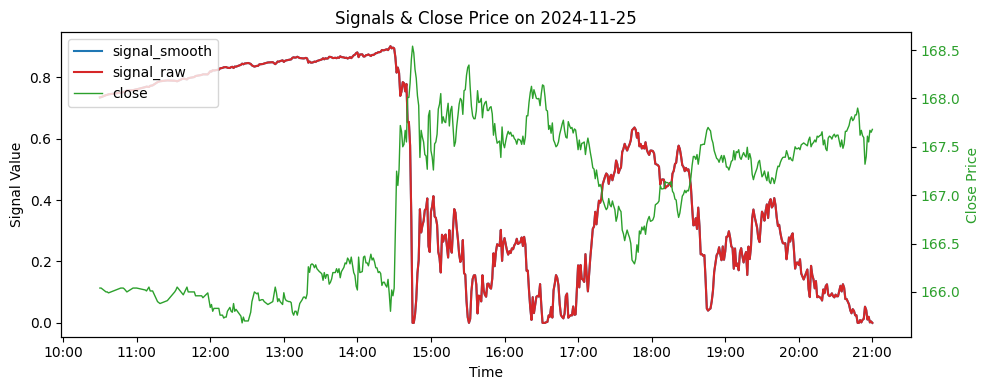

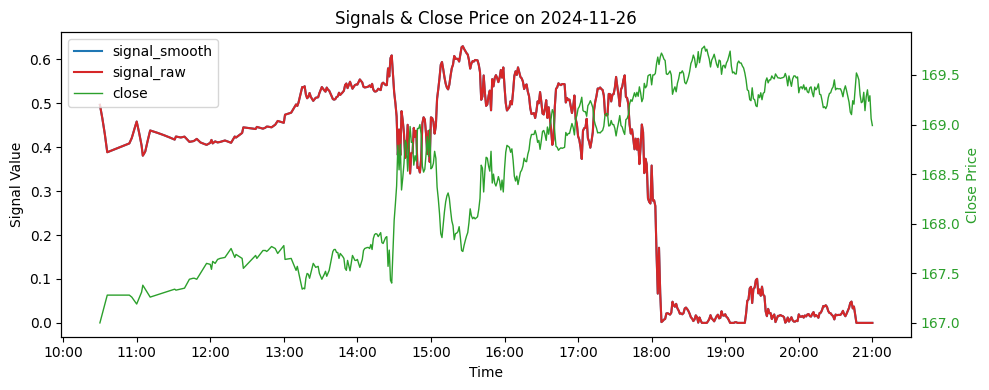

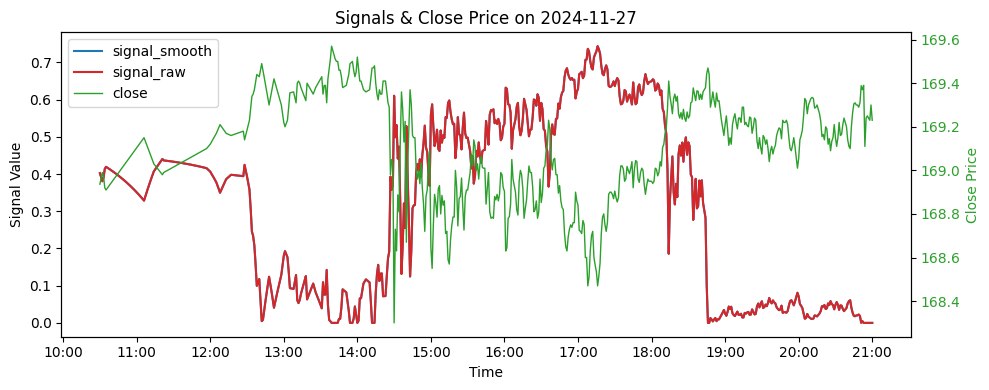

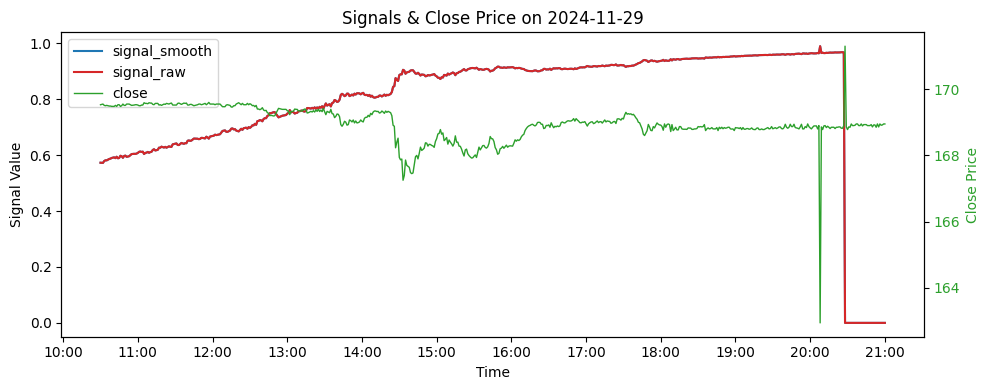

In [9]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal_smooth & signal_raw on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal_smooth"],
            color="tab:blue", lw=1.5, label="signal_smooth"
        )
        ax1.plot(
            df_day.index, df_day["signal_raw"],
            color="tab:red",  lw=1.5, label="signal_raw"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
